## Project Template (Deepnote)

You can use this notebook as a starting point for your class project and/or the extra exercise for graduate students in Deepnote. It comes set up with the dependencies we use in class, so you don't have to install these yourself.

**Notes:**
- To use this in your own workspace, click “Duplicate” for the project in Deepnote.
- Class dependencies, namely `drake` and the `manipulation` package, are already preinstalled in the Deepnote image for this course, as well as a bunch of other dependencies that these packages depend on or that we use in class
- To see the full list of installed dependencies, as well as version numbers etc, see this file: [pyproject.toml](https://github.com/RussTedrake/manipulation/blob/master/pyproject.toml).
  - **Note**: we install all the extra dependencies, including the `dev` dependencies, into the Docker image that this deepnote project runs on.


### (Advanced Users) Installing additional dependencies

Here we show you how to install additional packages into this Deepnote project. We will use the package [gcsopt](https://pypi.org/project/gcsopt/) as an example. To install additional dependencies, you have two choices:
- **Recommended** (automatically installs your dependencies every time you boot the Deepnote machine):
  1. Add the dependency to the list of dependencies in `reqirements.txt` on the left.  
      - **Note**: Make sure to NOT remove the text that is already in the file. You should add your dependencies on new lines AFTER `manipulation=year.month.day`. For our example, the file contents will look like:
          ```
          --extra-index-url https://drake-packages.csail.mit.edu/whl/nightly
          manipulation==2025.9.23
          gcsopt
          ```
  2. Restart the Deepnote machine (or run the `Init` notebook)
- **Alternatively:** Run `!pip install gcsopt` within a cell in the Deepnote notebook. You will have to do this everytime you restart your Deepnote machine.

### (Advanced Users) Updating the `manipulation` version
We continually add new features to the `manipulation` package, which is automatically updated in Deepnote. However, after you first click "Duplicate", you will stop receiving these updates. Follow these steps to update your version to the latest version:
1. Find the latest version number for `manipulation` on the [PyPi package page](https://pypi.org/project/manipulation/#history).
2. Update the version number for `manipulation=year.month.day` in the `requirements.txt` file on the left
3. Restart the Deepnote machine (or run the `Init` notebook)

The changes will persist every time you start your Deepnote machine.

Good luck!

---


## Placeholder code: iiwa Simulation

As a starting point, the code below sets up a simple simulation with a single iiwa, visualized in Meshcat.

### Setup and imports
Let us first get our imports out of the way:

In [60]:
from pydrake.all import (
    DiagramBuilder,
    Simulator,
    StartMeshcat,
    BasicVector,
    LeafSystem,
    InverseKinematics,
    SnoptSolver,
    RotationMatrix,
    RigidTransform,
    Solve,
    LogVectorOutput,
    PiecewisePolynomial,
    TrajectorySource,
    ImageWriter,
    PixelType
)

from manipulation.station import (
    LoadScenario,
    MakeHardwareStation,
)

from manipulation import running_as_notebook

import matplotlib.pyplot as plt
import numpy as np

### Meshcat Visualization

As always, let's start Meshcat for our 3D visualization!

In [61]:
import pygame

pygame.init()  # Initialize all Pygame modules
pygame.joystick.init() # Initialize the joystick module

joystick_count = pygame.joystick.get_count()
if joystick_count == 0:
    print("No joysticks found.")
else:
    # Initialize the first detected joystick (assuming one Xbox controller)
    joystick = pygame.joystick.Joystick(0)
    joystick.init()
    print(f"Controller detected: {joystick.get_name()}")

Controller detected: Xbox 360 Controller


In [100]:
import pygame
import time
import math

# --- Configuration ---
# Dead Zone: Ignore stick inputs closer to zero than this value (0.0 to 1.0)
DEAD_ZONE = 0.15 
# Polling Rate: How often to read and print the controller state (Hz)
POLLING_RATE_HZ = 60 

# --- Pygame Xbox Controller Mapping (Common Standard) ---
# Axes (Analog Sticks & Triggers, range -1.0 to 1.0 or 0.0 to 1.0)
AXIS_LEFT_X  = 0
AXIS_LEFT_Z  = 1
AXIS_RIGHT_X = 2
AXIS_RIGHT_Z = 3
AXIS_LEFT_TRIGGER  = 4 # Often 0.0 (off) to 1.0 (full press)
AXIS_RIGHT_TRIGGER = 5 # Often 0.0 (off) to 1.0 (full press)

# Buttons (Digital Bumpers, range 0 or 1)
# NOTE: These constants (4 and 5) are LIKELY WRONG for your Mac setup.
# # >>> YOU NEED TO UPDATE THESE NUMBERS <<<
BUTTON_DPAD_LEFT  = 13
BUTTON_DPAD_RIGHT = 14

def filter_stick_input(value):
    """
    Applies a dead zone filter and scales the remaining input linearly.
    """
    if abs(value) < DEAD_ZONE:
        return 0.0
    
    # Scale the value from [DEAD_ZONE, 1] to [0, 1]
    # (and [-1, -DEAD_ZONE] to [-1, 0])
    scaled_value = (abs(value) - DEAD_ZONE) / (1.0 - DEAD_ZONE)
    return math.copysign(scaled_value, value)

def initialize_controller():
    """Initializes pygame and attempts to find a controller."""
    try:
        pygame.init()
        pygame.joystick.init()
    except Exception as e:
        print(f"Error initializing Pygame: {e}")
        return None

    joystick_count = pygame.joystick.get_count()
    if joystick_count == 0:
        print("No joystick/controller detected.")
        return None

    controller = pygame.joystick.Joystick(0)
    controller.init()
    print(f"Controller Connected: {controller.get_name()}")
    print(f"Total Buttons Detected: {controller.get_numbuttons()}")
    print(f"Total Axes Detected: {controller.get_numaxes()}")
    print("-" * 50)
    print("If Roll doesn't work, press LB and RB to see if the BUTTONS debug line shows '1' at a different index.")
    return controller

def run_mapper():
    """Main loop to read and map controller inputs."""
    controller = initialize_controller()
    if not controller:
        # Wait a bit before exiting if no controller found, allowing user to plug one in
        time.sleep(2)
        return

    running = True
    clock = pygame.time.Clock()
    
    while running:
        # Event pump is REQUIRED to update the controller state (essential for Pygame)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.JOYBUTTONDOWN:
                # Allows the user to quit by pressing the START button (often button 7)
                if event.button == 7: 
                    running = False
            elif event.type == pygame.JOYDEVICEREMOVED:
                print("\nController disconnected. Exiting.")
                running = False


        # --- READ RAW INPUTS ---
        
        # Left Stick (X/Y)
        raw_lx = controller.get_axis(AXIS_LEFT_X)
        raw_lz = controller.get_axis(AXIS_LEFT_Z)
        
        # Right Stick (X/Y)
        raw_rx = controller.get_axis(AXIS_RIGHT_X)
        raw_rz = controller.get_axis(AXIS_RIGHT_Z)

        # Triggers (0.0 to 1.0)
        raw_lt = controller.get_axis(AXIS_LEFT_TRIGGER)
        raw_rt = controller.get_axis(AXIS_RIGHT_TRIGGER)
        
        # Bumpers (0 or 1)
        # Check if the controller has enough buttons to read 4 and 5
        num_buttons = controller.get_numbuttons()
    
        
        # --- XYZ Translation (Movement) ---
        # X (Surge - Left/Right): Left Stick X
        X = filter_stick_input(raw_lx)
        
        # Y (Heave - Forward/Back): Left Stick Y
        # Pygame's Y-axis is often inverted (-1.0 is UP/Forward). We invert it here
        # so positive Y value means positive direction (usually Forward or Up).
        Z = filter_stick_input(-raw_lz) 
        
        # Z (Vertical/Thrust): Right Trigger (Positive) - Left Trigger (Negative)
        # Assumes triggers range 0.0 to 1.0. Result is -1.0 to 1.0.
        Y = raw_rt - raw_lt 
        

        # --- RPY Rotation (Angular) ---
        
        # Roll (Around X-axis): Right Bumper (Positive) - Left Bumper (Negative)
        # Uses the current button state read above
        Roll = 0
        # hat_input = controller.get_hat(0)
        # hat_x = hat_input[0] 
        # Roll = float(hat_x)
        
        # Pitch (Around Y-axis): Right Stick Y
        # Invert Y for intuitive control (pull back = positive pitch / nose up)
        Pitch = filter_stick_input(-raw_rz) 
        
        # Yaw (Around Z-axis): Right Stick X
        Yaw = filter_stick_input(raw_rx)


        # --- OUTPUT ---
        
        # Collect button states for debugging
        button_states = []
        # Limiting to 10 buttons (indices 0-9) for a clean debug line
        for i in range(min(num_buttons, 15)):
            try:
                button_states.append(str(controller.get_button(i)))
            except:
                button_states.append('X') # Mark unavailable buttons
        
        button_debug = f"BUTTONS [0-9]: {'|'.join(button_states)}"
        
        # Print results to the console, clearing the line for real-time display
        output = (
            f"XYZ Movement | X:{X:+.2f} | Y:{Y:+.2f} | Z:{Z:+.2f} | "
            f"RPY Rotation | R:{Roll:+.2f} | P:{Pitch:+.2f} | Y:{Yaw:+.2f} | "
            f"{button_debug}"
        )
        print(output, end='\r')

        # Control the loop frequency
        clock.tick(POLLING_RATE_HZ)

    # Clean up when the loop exits
    pygame.quit()

run_mapper()


Controller Connected: Xbox 360 Controller
Total Buttons Detected: 15
Total Axes Detected: 6
--------------------------------------------------
If Roll doesn't work, press LB and RB to see if the BUTTONS debug line shows '1' at a different index.


KeyboardInterrupt: 

In [40]:
# Start meshcat for visualization
meshcat = StartMeshcat()
print("Click the link above to open Meshcat in your browser!")

INFO:drake:Meshcat listening for connections at http://localhost:7002


Click the link above to open Meshcat in your browser!


In [68]:
scenario_string = """directives:
# add robot
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
      iiwa_joint_1: [-1.57]
      iiwa_joint_2: [0.1]
      iiwa_joint_3: [0]
      iiwa_joint_4: [-1.2]
      iiwa_joint_5: [0]
      iiwa_joint_6: [1.6]
      iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0

# add gripper
- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}

# add camera mounted to world 
- add_frame:
    name: camera0_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [270, 0.0, 90.0]}
        translation: [1.2, -0.5, 0.5]
- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: camera0_origin
    child: camera0::base

# add camera mounted to robot wrist
- add_frame:
    name: camera_wrist
    X_PF:
      base_frame: iiwa::iiwa_link_7
      translation: [-0.05, 0, 0.1]   # 10 cm ahead of wrist
      rotation: !Rpy {deg: [0, 00, -90]}
- add_model:
    name: camera1
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: iiwa::camera_wrist
    child: camera1::base

# add cabinet
- add_model:
    name: cabinet
    file: package://drake_models/manipulation_station/cupboard.sdf
- add_frame:
    name: cabinet_origin
    X_PF:
      base_frame: world
      translation: [0, -1.1, 0.4]    # x, y, z in meters
      rotation: !Rpy { deg: [0, 0, 90]}  # roll, pitch, yaw
- add_weld:
    parent: cabinet_origin
    child: cabinet::cupboard_body

cameras:
  camera0:
    name: camera0
    depth: True
    X_PB:
      base_frame: camera0::base
  camera1:
    name: camera1
    depth: True
    X_PB:
      base_frame: camera1::base

model_drivers:
  iiwa: !IiwaDriver
    control_mode: position_only 
    hand_model_name: wsg
  wsg: !SchunkWsgDriver {}
"""

# scenario = LoadScenario(data=scenario_string)
# station = MakeHardwareStation(scenario, meshcat=meshcat)
# builder = DiagramBuilder()
# builder.AddSystem(station)
# diagram = builder.Build()
# context = diagram.CreateDefaultContext()

# simulator = Simulator(diagram)
# simulator.set_target_realtime_rate(1.0)
# simulator.AdvanceTo(0.0)

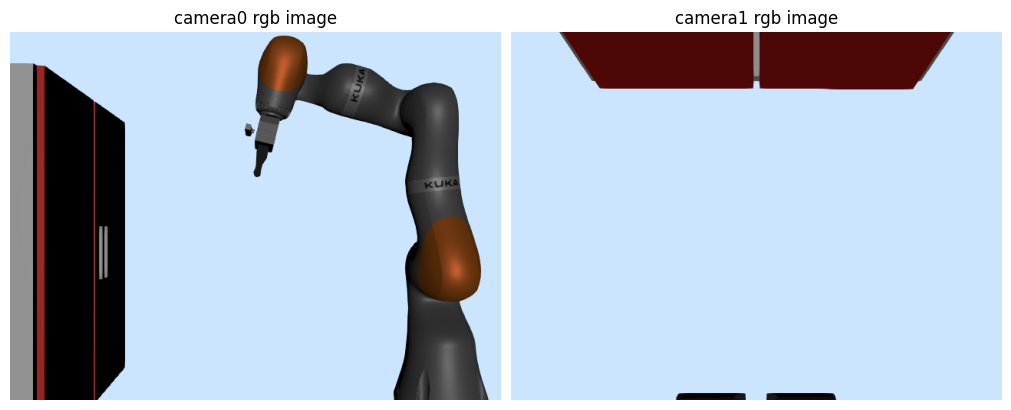

In [69]:
# run the following cell to visualize the rgb outputs of each of the cameras
cameras = ["camera0", "camera1"]
context = diagram.CreateDefaultContext()

station_context = diagram.GetSubsystemContext(station, context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
# cam = cameras[0]
# ax = axes
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

if running_as_notebook:
    plt.show()

# Teleopping

In [104]:
class TeleopController(LeafSystem):
    """
    Buttons for end-effector pose to joint positions via ik
    """
    def __init__(self, meshcat, plant):
        LeafSystem.__init__(self)
        
        # Movement params
        self.STEP_SIZE_M = 0.01  
        self.STEP_SIZE_RAD = 0.087 # ~5 degrees
        
        # --- PYGAME & CONTROLLER INITIALIZATION ---
        try:
            pygame.init()
            pygame.joystick.init()
            if pygame.joystick.get_count() == 0:
                print("ERROR: No joystick/controller detected! Teleop will be disabled.")
                self.controller = None
            else:
                self.controller = pygame.joystick.Joystick(0)
                self.controller.init()
                print(f"Controller Connected: {self.controller.get_name()}")
        except Exception as e:
            print(f"ERROR: Pygame initialization failed: {e}")
            self.controller = None

        
        self.meshcat = meshcat
        self.plant = plant
        
        # getting the necessary frames
        self.plant_context = plant.CreateDefaultContext()
        self.W_frame = plant.world_frame()

        wsg_instance = self.plant.GetModelInstanceByName("wsg")
        wsg_link = self.plant.GetBodyByName("body", wsg_instance)
        self.WG_frame = wsg_link.body_frame()
        
        self.nq = 7 
        
        # Configuration for IK
        self.q_initial = np.array([-1.57, 0.2, 0, -1.2, 0, 1.6, 0])
        self.iiwa = self.plant.GetModelInstanceByName("iiwa")
        first_iiwa_joint = self.plant.GetJointByName("iiwa_joint_1", self.iiwa)

        self.iiwa_q_start_index = first_iiwa_joint.position_start()
        
        # Initialize positions
        plant.SetPositions(self.plant_context, self.iiwa, self.q_initial)
        
        # initialize blank desired states
        self.X_WG_desired = plant.CalcRelativeTransform(
            self.plant_context, self.W_frame, self.WG_frame
        )
        self.R_WG_desired = self.X_WG_desired.rotation()
        self.q_desired = self.q_initial
        self.wsg_position_desired = 0.1

        # Register output ports for IIWA and WSG commands
        self.DeclareVectorOutputPort(
            "iiwa_position_command", 
            BasicVector(self.nq), 
            self.DoCalcIiwaOutput
        )
        self.DeclareVectorOutputPort(
            "wsg_position_command", 
            BasicVector(1), 
            lambda context, output: output.SetFromVector([self.wsg_position_desired])
        )

        # TODO: Convert buttons on meshcat simulation to keybindings
        
        # self.button_map = {
        #     "Move +X (Forward)": np.array([self.STEP_SIZE_M, 0, 0]),
        #     "Move -X (Backward)": np.array([-self.STEP_SIZE_M, 0, 0]),
        #     "Move +Y (Right)": np.array([0, self.STEP_SIZE_M, 0]),
        #     "Move -Y (Left)": np.array([0, -self.STEP_SIZE_M, 0]),
        #     "Move +Z (Up)": np.array([0, 0, self.STEP_SIZE_M]),
        #     "Move -Z (Down)": np.array([0, 0, -self.STEP_SIZE_M]),
        #     "Open Gripper (O)": "OPEN",
        #     "Close Gripper (C)": "CLOSE",
            
        #     # Roll (Around X-axis of the World Frame)
        #     "Roll +X": "ROT_X_P",
        #     "Roll -X": "ROT_X_N",
        #     # Pitch (Around Y-axis of the World Frame)
        #     "Pitch +Y": "ROT_Y_P",
        #     "Pitch -Y": "ROT_Y_N",
        #     # Yaw (Around Z-axis of the World Frame)
        #     "Yaw +Z": "ROT_Z_P",
        #     "Yaw -Z": "ROT_Z_N",
        # }

        
        # self.last_click_counts = {}
        
        # print("\n--- Teleoperation Controls (Meshcat Buttons) ---")
        # for button_name in self.button_map.keys():
        #     meshcat.AddButton(button_name)
        #     self.last_click_counts[button_name] = 0
        #     print(f"Button added: {button_name}")
        
        meshcat.AddButton("Stop Simulation") 

    def read_controller_inputs(self):
        """
        Reads the current state of the Xbox controller and returns normalized 
        XYZ/RPY values.
        """
        if not self.controller:
            return None, None
            
        # Must pump events for Pygame to update controller state
        pygame.event.pump()
        
        # Read raw stick/trigger inputs
        raw_lx = self.controller.get_axis(AXIS_LEFT_X)
        raw_lz = self.controller.get_axis(AXIS_LEFT_Z)
        raw_rx = self.controller.get_axis(AXIS_RIGHT_X)
        raw_rz = self.controller.get_axis(AXIS_RIGHT_Z)

        raw_lt = self.controller.get_axis(AXIS_LEFT_TRIGGER)
        raw_rt = self.controller.get_axis(AXIS_RIGHT_TRIGGER)
        
        # Read digital bumper states

        # --- XYZ Translation (Movement) ---
        # X (Surge - Left/Right)
        Y = filter_stick_input(raw_lx)
        # Y (Heave - Forward/Back): Invert Y for forward = positive
        Z = filter_stick_input(raw_lz) 
        # Z (Vertical/Thrust): Trigger difference
        X = raw_rt - raw_lt 
        
        btn_gripper_close = self.controller.get_button(0) # A button
        btn_gripper_open  = self.controller.get_button(1) # B button
        # --- RPY Rotation (Angular) ---
        # Roll: Bumper difference
        
        btn_left  = self.controller.get_button(BUTTON_DPAD_LEFT)
        btn_right = self.controller.get_button(BUTTON_DPAD_RIGHT)
        Pitch = float(btn_right - btn_left)
        # Pitch: Right Stick Y (Invert Y for pull back = positive pitch / nose up)
        Roll = filter_stick_input(raw_rz) 
        # Yaw: Right Stick X
        Yaw = filter_stick_input(raw_rx)
        
        translation_vector = np.array([X, Y, Z])
        rotation_vector = np.array([Roll, Pitch, Yaw])
        
        # Return full 6DOF input and gripper state (A/B buttons)
        return translation_vector, rotation_vector, btn_gripper_close, btn_gripper_open
    def step_control(self):
        """
        checks for update events
        """
    
        if not self.controller:
            return

        # 1. Read all inputs
        translation_input, rotation_input, btn_a, btn_b = self.read_controller_inputs()
        
        # 2. Update End-Effector Pose (XYZ)
        
        # Scale the normalized input vector by the maximum step distance
        delta_p = translation_input * self.STEP_SIZE_M
        
        # Apply translation only if magnitude is above a tiny threshold
        moved_p = np.linalg.norm(delta_p) > 1e-4
        if moved_p:
            self.X_WG_desired.set_translation(
                self.X_WG_desired.translation() + delta_p
            )
            
        # 3. Update End-Effector Rotation (RPY)
        
        # Scale the normalized angular input vector by the maximum step angle
        roll_rate, pitch_rate, yaw_rate = rotation_input * self.STEP_SIZE_RAD

        # Create the incremental rotation matrix (drake uses Z-Y-X or RPY rotation)
        # We apply the rates in order (X-Y-Z for Roll, Pitch, Yaw)
        delta_R = RotationMatrix.MakeXRotation(roll_rate) \
                  .multiply(RotationMatrix.MakeYRotation(pitch_rate)) \
                  .multiply(RotationMatrix.MakeZRotation(yaw_rate))
                  
        # Apply rotation only if there is significant angular input
        moved_R = np.linalg.norm(rotation_input) > 1e-4

        if moved_R:
            # Pre-multiply the delta_R to the current R_WG_desired
            # This applies rotation in the World Frame (W)
            self.R_WG_desired = delta_R.multiply(self.R_WG_desired)

        # 4. Update Gripper State
        if btn_a == 1: # A button (usually closes the gripper)
            self.wsg_position_desired = 0.0
        elif btn_b == 1: # B button (usually opens the gripper)
            self.wsg_position_desired = 0.1
            
        # 5. Recalculate IK if any change occurred
        if moved_p or moved_R or btn_a == 1 or btn_b == 1:
            self.X_WG_desired = RigidTransform(self.R_WG_desired, self.X_WG_desired.translation())
            self._calculate_ik()
            
    def _calculate_ik(self):
        """
        Finds the joint positions (q_desired) that best match the desired
        end-effector pose (X_WG_desired), using the last valid solution as a seed.
        """
        print("finding IK solution...")
        ik = InverseKinematics(self.plant, self.plant_context)
        
        # define decision variables for only the IIWA joints
        q_iiwa = ik.q()[self.iiwa_q_start_index : self.iiwa_q_start_index + self.nq]
        
        p_WG_W = self.X_WG_desired.translation()
        ik.AddPositionConstraint(
            self.WG_frame, [0, 0, 0], self.W_frame, p_WG_W, p_WG_W
        )
        
        R_WG_W = self.X_WG_desired.rotation()
        ik.AddOrientationConstraint(
            self.WG_frame, R_WG_W, self.W_frame, RotationMatrix(), 0.05
        )
        
        prog = ik.prog()
        q_current = self.q_desired
        
        # cost minimizes distance b/w current and future state
        prog.AddQuadraticErrorCost(
            np.identity(self.nq), 
            q_current, 
            q_iiwa
        )
        
        solver = SnoptSolver()
        
        # set initial guess
        q_full_initial_guess = self.plant.GetPositions(self.plant_context)
        
        result = solver.Solve(prog, initial_guess=q_full_initial_guess)

        if result.is_success():
            # update positions
            q_full_result = result.GetSolution(ik.q())
            q_iiwa_result = q_full_result[self.iiwa_q_start_index : self.iiwa_q_start_index + self.nq]
            
            self.q_desired = q_iiwa_result
            self.plant.SetPositions(self.plant_context, self.iiwa, self.q_desired)
        else:
            print(f"IK Warning: Failed to find joint solution. Check if target is reachable.")
            
    def DoCalcIiwaOutput(self, context, output):
        """
        Outputs the latest calculated joint position command.
        """
        output.SetFromVector(self.q_desired)

Run simulation to collect teleoperation data and save it to files.

In [105]:
target_dt = 0.05  # 20 Hz

scenario = LoadScenario(data=scenario_string)
station = MakeHardwareStation(scenario, meshcat=meshcat)
builder = DiagramBuilder()
builder.AddSystem(station)
image_writer = builder.AddSystem(ImageWriter())
plant = station.GetSubsystemByName("plant") 

camera_world = station.GetSubsystemByName("rgbd_sensor_camera0")
camera_wrist = station.GetSubsystemByName("rgbd_sensor_camera1")


# add controller
controller = builder.AddSystem(TeleopController(meshcat, plant))

# add logger
logger_joints = LogVectorOutput(controller.GetOutputPort("iiwa_position_command"), builder)
logger_gripper = LogVectorOutput(controller.GetOutputPort("wsg_position_command"), builder)

# Connect controller outputs to station inputs
builder.Connect(
    controller.GetOutputPort("iiwa_position_command"),
    station.GetInputPort("iiwa.position")
)
builder.Connect(
    controller.GetOutputPort("wsg_position_command"),
    station.GetInputPort("wsg.position")
)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
station_context = diagram.GetSubsystemContext(station, context)

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)

print("\n--- Starting Cartesian Teleop Demo ---")
print("Please focus the Meshcat viewer window to enable keyboard input.")

image_data_camera0 = []
image_data_camera1 = []
image_timestamps = []

# Run until the user clicks the "Stop Simulation" button in Meshcat
while meshcat.GetButtonClicks('Stop Simulation') == 0:
    controller.step_control()
    
    simulator.AdvanceTo(simulator.get_context().get_time() + target_dt)

    sim_context = simulator.get_context()
    station_context = diagram.GetSubsystemContext(station, sim_context)

    # Grab the current images from the output ports
    img0 = station.GetOutputPort("camera0.rgb_image").Eval(station_context)  # ImageRgba8U object
    img1 = station.GetOutputPort("camera1.rgb_image").Eval(station_context)  # ImageRgba8U object

    # Convert to numpy arrays for easier handling
    np_img0 = np.array(np.copy(img0.data)).reshape(img0.height(), img0.width(), -1)  # RGBA
    np_img1 = np.array(np.copy(img1.data)).reshape(img1.height(), img1.width(), -1)

    image_data_camera0.append(np_img0)
    image_data_camera1.append(np_img1)
    image_timestamps.append(sim_context.get_time())

print("Simulation stopped by user.")

np.savez(
    "teleop_data/image_timestamps.npz",
    time=np.array(image_timestamps)
)

Controller Connected: Xbox 360 Controller

--- Starting Cartesian Teleop Demo ---
Please focus the Meshcat viewer window to enable keyboard input.
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
finding IK solution...
fi

Save images to teleop_data folder if we want. Otherwise, images are stored in image_data_camera0 and image_data_camera1.

In [ ]:
from imageio import imwrite

for i, img in enumerate(image_data_camera0):
    imwrite(f"teleop_data/camera_0/frame_{i:04d}.png", img[:, :, :3])

for i, img in enumerate(image_data_camera1):
    imwrite(f"teleop_data/camera_1/frame_{i:04d}.png", img[:, :, :3])

Downsample collected data to 100Hz and save.

In [58]:
# Save original joint data to teleop_joint_data.npz
joint_log_data = logger_joints.FindLog(simulator.get_context())
joint_q_log = joint_log_data.data()        # shape (nq, N)
joint_t_log = joint_log_data.sample_times()  # shape (N,)
np.savez("teleop_data/teleop_joint_data.npz", time=joint_t_log, q=joint_q_log)
print(joint_q_log)
print(joint_t_log)

# Save original gripper data to teleop_gripper_data.npz
gripper_log_data = logger_gripper.FindLog(simulator.get_context())
gripper_q_log = gripper_log_data.data()        # shape (1, N)
gripper_t_log = gripper_log_data.sample_times()  # shape (N,)
np.savez("teleop_data/teleop_gripper_data.npz", time=gripper_t_log, q=gripper_q_log)
print(gripper_q_log)
print(gripper_t_log)

joint_t_uniform = np.arange(joint_t_log[0], joint_t_log[-1], target_dt)
joint_q_uniform = np.empty((joint_q_log.shape[0], len(joint_t_uniform)))

for i in range(joint_q_log.shape[0]):
    joint_q_uniform[i, :] = np.interp(joint_t_uniform, joint_t_log, joint_q_log[i, :])

np.savez("teleop_data/downsampled_teleop_joint_data.npz", time=joint_t_uniform, q=joint_q_uniform)

print(joint_t_uniform)
print(joint_q_uniform)

gripper_t_uniform = np.arange(gripper_t_log[0], gripper_t_log[-1], target_dt)
gripper_q_uniform = np.empty((gripper_q_log.shape[0], len(gripper_t_uniform)))

for i in range(gripper_q_log.shape[0]):
    gripper_q_uniform[i, :] = np.interp(gripper_t_uniform, gripper_t_log, gripper_q_log[i, :])

np.savez("teleop_data/downsampled_teleop_gripper_data.npz", time=gripper_t_uniform, q=gripper_q_uniform)

print(gripper_t_uniform)
print(gripper_q_uniform)

[[ 0.69786922  0.69786922  0.69786922 ... -0.98898105 -0.98898105
  -0.98898105]
 [-1.59847748 -1.59847748 -1.59847748 ... -1.62630689 -1.62630689
  -1.62630689]
 [-1.16799378 -1.16799378 -1.16799378 ...  1.37684008  1.37684008
   1.37684008]
 ...
 [-1.32862525 -1.32862525 -1.32862525 ... -1.38746981 -1.38746981
  -1.38746981]
 [-1.0600835  -1.0600835  -1.0600835  ...  1.51321353  1.51321353
   1.51321353]
 [-1.15376268 -1.15376268 -1.15376268 ... -3.05432619 -3.05432619
  -3.05432619]]
[0.000e+00 1.000e-04 6.000e-04 ... 9.198e+00 9.199e+00 9.200e+00]
[[0.1 0.1 0.1 ... 0.1 0.1 0.1]]
[0.000e+00 1.000e-04 6.000e-04 ... 9.198e+00 9.199e+00 9.200e+00]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35

Replay collected joint and gripper data. (Need to restart kernel, run first three cells to import dependencies and define scenario_string and meshcat, then run this cell.)

In [6]:
joint_data = np.load("downsampled_teleop_joint_data.npz")
joint_t_uniform = joint_data["time"]
joint_q_uniform = joint_data["q"]

gripper_data = np.load("downsampled_teleop_gripper_data.npz")
gripper_t_uniform = gripper_data["time"]
gripper_q_uniform = gripper_data["q"]

scenario = LoadScenario(data=scenario_string)
station = MakeHardwareStation(scenario, meshcat=meshcat)
plant = station.GetSubsystemByName("plant") 

traj_iiwa = PiecewisePolynomial.FirstOrderHold(joint_t_uniform, joint_q_uniform)
traj_wsg = PiecewisePolynomial.FirstOrderHold(gripper_t_uniform, gripper_q_uniform)

builder = DiagramBuilder()
builder.AddSystem(station)  # your station system already created

# Create trajectory sources
iiwa_source = builder.AddSystem(TrajectorySource(traj_iiwa))
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg))

# Connect to the plant
builder.Connect(iiwa_source.get_output_port(0),
                station.GetInputPort("iiwa.position"))
builder.Connect(wsg_source.get_output_port(0),
                station.GetInputPort("wsg.position"))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)

# Run for the duration of the trajectory
simulator.AdvanceTo(joint_t_uniform[-1])

print("Replay finished!")

Replay finished!


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf4fb7c2-18e7-48b8-93e7-63f0209e538b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>